In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC


C:\Users\new user\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.sparse import csr_matrix, issparse


In [2]:

# --- 1. Load Feature Names ---
# This step is needed to get the 'features' variable you used.
# We read the 2nd column (index 1) from features.txt.
try:
    features_df = pd.read_csv('UCI HAR Dataset/features.txt', delim_whitespace=True, header=None)
    feature_names = features_df[1].tolist()
except FileNotFoundError:
    print("Error: 'features.txt' not found. Make sure it's in the 'UCI HAR Dataset' folder.")
    # You would typically exit or handle this error, but for demonstration:
    feature_names = [] # Set to empty list to show the error

# --- 2. Load Training Data (X_train) ---
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)

# Set the column names
if feature_names:
    X_train.columns = feature_names # <-- Fixed: No extra brackets [ ]
else:
    print("Warning: Feature names not loaded. Columns will be numbered.")

# --- 3. Load Subject Data ---
# FIX: Read the CSV, then select the first column (index 0) to get a Series.
subject_series = pd.read_csv('UCI HAR Dataset/train/subject_train.txt', header=None)[0]

# --- 4. Load Activity Labels (y_train) ---
# FIX: Read with a proper column name, then select that column to get a Series.
y_train_series = pd.read_csv('UCI HAR Dataset/train/y_train.txt', header=None, names=['Activity'])['Activity']

# --- 5. Combine All Data into One DataFrame ---
# It's good practice to copy X_train to avoid modifying the original
train = X_train.copy()

# Add the new columns
train['subject'] = subject_series
train['Activity'] = y_train_series

# --- 6. Map Activity Names ---
# Your mapping code is perfect!
activity_map = {
    1: 'WALKING', 
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING', 
    5: 'STANDING',
    6: 'LAYING'
}

train['ActivityName'] = train['Activity'].map(activity_map)

# --- 7. Display a Sample ---
# Using .head() or .sample() is a great way to check your work
print("Data loaded successfully. Displaying first few data set:")
train.head(2)



C:\Users\new user\AppData\Local\Temp\ipykernel_6788\1967201394.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features_df = pd.read_csv('UCI HAR Dataset/features.txt', delim_whitespace=True, header=None)
C:\Users\new user\AppData\Local\Temp\ipykernel_6788\1967201394.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)


Data loaded successfully. Displaying first few data set:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING


In [3]:
# --- 1. Load Test Data (X_test) ---
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)

# Set the column names
if 'feature_names' in locals():
    X_test.columns = feature_names # <-- Fixed: No extra brackets [ ]
else:
    print("Warning: 'feature_names' not found. Columns will be numbered.")

# --- 2. Load Subject Data ---
# FIX: Read the CSV, then select the first column (index 0) to get a Series.
subject_series_test = pd.read_csv('UCI HAR Dataset/test/subject_test.txt', header=None)[0]

# --- 3. Load Activity Labels (y_test) ---
# FIX: Read with a proper column name, then select that column to get a Series.
y_test_series = pd.read_csv('UCI HAR Dataset/test/y_test.txt', header=None, names=['Activity'])['Activity']

# --- 4. Combine All Data into One DataFrame ---
# Use .copy() to prevent SettingWithCopyWarning
test = X_test.copy()

# Add the new columns
test['subject'] = subject_series_test
test['Activity'] = y_test_series

# --- 5. Map Activity Names ---
# Your mapping code is perfect!
activity_map = {
    1: 'WALKING', 
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING', 
    5: 'STANDING',
    6: 'LAYING'
}

test['ActivityName'] = test['Activity'].map(activity_map)

# --- 6. Display a Sample ---
print("Test data loaded successfully. Displaying a random sample:")
print(test.head(2))


C:\Users\new user\AppData\Local\Temp\ipykernel_6788\2637941692.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)


Test data loaded successfully. Displaying a random sample:
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.257178          -0.023285          -0.014654         -0.938404   
1           0.286027          -0.013163          -0.119083         -0.975415   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.920091         -0.667683         -0.952501         -0.925249   
1         -0.967458         -0.944958         -0.986799         -0.968401   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  angle(tBodyAccMean,gravity)  \
0         -0.674302         -0.894088  ...                     0.006462   
1         -0.945823         -0.894088  ...                    -0.083495   

   angle(tBodyAccJerkMean),gravityMean)  angle(tBodyGyroMean,gravityMean)  \
0                               0.16292                         -0.825886   
1                               0.01750                         -0.434375   

   angle(t

In [4]:
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train.ActivityName

X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test.ActivityName

print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((7352, 561),(7352,))
X_test  and y_test  : ((2947, 561),(2947,))


In [5]:
#Labels that are useful in plotting confusion matrix
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
#Let's make a function to plot the confusion matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
from datetime import datetime
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done....!\n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done....!\n')
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
   
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(6,6))
    
    # --- THIS IS THE FIX ---
    plt.grid(False) # Changed from plt.grid(b=False)
    # -----------------------
    
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('****************| Classifiction Report |****************')
    classification_report = metrics.classification_report(y_test, y_pred)
   
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results

In [7]:
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))


    # parameters that gave best results while performing grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))


    #  number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal numbre of cross validation sets: {}'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search 
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of best estimator : {}'.format(model.best_score_))

    

Running GridSearchCV for PCA + SVM...
training the model..
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Done....!

==> training time:- 0:00:46.963905

Predicting test data
Done....!

==> testing time:- 0:00:00.066276

==> Accuracy:- 0.9216152019002375


 ********Confusion Matrix********

 [[536   0   1   0   0   0]
 [  3 422  65   0   0   1]
 [  0  39 493   0   0   0]
 [  0   0   0 479  13   4]
 [  0   0   0   7 373  40]
 [  0   0   0  31  27 413]]


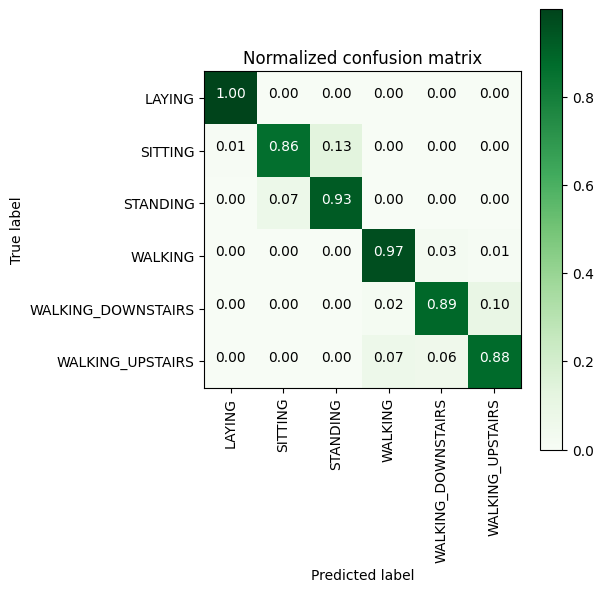

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.92      0.86      0.89       491
          STANDING       0.88      0.93      0.90       532
           WALKING       0.93      0.97      0.95       496
WALKING_DOWNSTAIRS       0.90      0.89      0.90       420
  WALKING_UPSTAIRS       0.90      0.88      0.89       471

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



==> Best Estimator:
	Pipeline(steps=[('scaler', StandardScaler()),
                ('dim_red', PCA(n_components=0.95)),
                ('model', SVC(C=1, cache_size=500, kernel='linear'))])


==> Best parameters:
	Parameters of best estimator : {'model__C': 1, 'model__kernel': 'linear'}

==> No. of CrossValidation sets:
	Total numbre o

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# --- 1. Define the SVM parameters (THIS IS SHARED) ---
# We can re-use this grid for both pipelines
C_values = [0.01, 0.1, 1, 10, 100]

grid_1 = {
    'model__kernel': ['linear'],
    'model__C': C_values
}
grid_2 = {
    'model__kernel': ['rbf'],
    'model__C': C_values,
    'model__gamma': ['scale', 0.1, 0.01]
}
parameters_svm = [grid_1, grid_2]


# --- 2. PCA Pipeline Setup (Unsupervised) ---
# This is the pipeline you already had
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_red', PCA(n_components=0.95)),  # Use a generic name 'dim_red'
    ('model', SVC(cache_size=500))
])

# Setup GridSearchCV for the PCA pipeline
print("Running GridSearchCV for PCA + SVM...")
svm_grid_pca = GridSearchCV(
    pca_pipeline,
    param_grid=parameters_svm, # Uses the shared SVM parameters
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run the PCA model
svm_grid_pca_results = perform_model(
    svm_grid_pca, 
     X_train, y_train, X_test, y_test, 
     class_labels=labels
 )
print_grid_search_attributes(svm_grid_pca_results['model'])



Running GridSearchCV for LDA + SVM...
training the model..
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Done....!

==> training time:- 0:00:09.257075

Predicting test data
Done....!

==> testing time:- 0:00:00.096167

==> Accuracy:- 0.9650492025788938


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 434  56   0   0   1]
 [  0  22 510   0   0   0]
 [  0   0   0 490   0   6]
 [  0   0   0   1 411   8]
 [  0   0   0   9   0 462]]


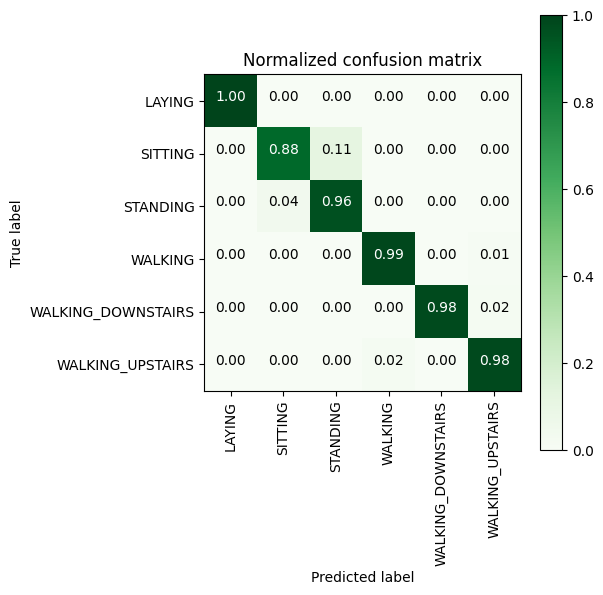

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.95      0.88      0.92       491
          STANDING       0.90      0.96      0.93       532
           WALKING       0.98      0.99      0.98       496
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
  WALKING_UPSTAIRS       0.97      0.98      0.97       471

          accuracy                           0.97      2947
         macro avg       0.97      0.96      0.97      2947
      weighted avg       0.97      0.97      0.96      2947



==> Best Estimator:
	Pipeline(steps=[('scaler', StandardScaler()),
                ('dim_red', LinearDiscriminantAnalysis()),
                ('model', SVC(C=1, cache_size=500))])


==> Best parameters:
	Parameters of best estimator : {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}

==> No. of CrossValidation sets:
	Tot

In [10]:
# --- 3. LDA Pipeline Setup (Supervised) ---
# This pipeline replaces PCA with LDA
lda_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_red', LDA()),  # 'dim_red' step is now LDA
    ('model', SVC(cache_size=500))
])

# Setup GridSearchCV for the LDA pipeline
print("\nRunning GridSearchCV for LDA + SVM...")
svm_grid_lda = GridSearchCV(
    lda_pipeline,
    param_grid=parameters_svm, # Uses the *same* SVM parameters
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run the LDA model
svm_grid_lda_results = perform_model(
     svm_grid_lda, 
     X_train, y_train, X_test, y_test, 
     class_labels=labels
 )
print_grid_search_attributes(svm_grid_lda_results['model'])

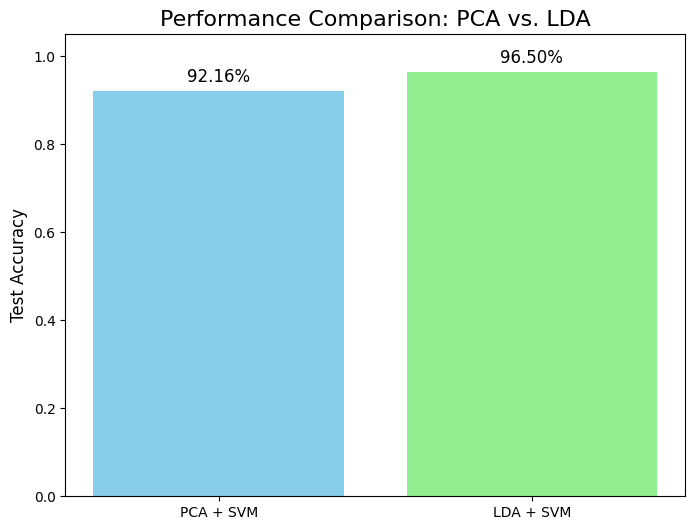

In [11]:
# --- (Run this cell AFTER your models are done training) ---

# 1. Get the final accuracies
try:
    acc_pca = svm_grid_pca_results['accuracy']
    acc_lda = svm_grid_lda_results['accuracy']
    
    model_names = ['PCA + SVM', 'LDA + SVM']
    accuracies = [acc_pca, acc_lda]

    # 2. Create the bar plot
    plt.figure(figsize=(8, 6))
    bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen'])
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title('Performance Comparison: PCA vs. LDA', fontsize=16)
    plt.ylim(0, 1.05) # Set y-axis from 0 to 105%
    
    # 3. Add the accuracy percentage on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval*100:.2f}%', 
                 ha='center', va='bottom', fontsize=12)
                 
    plt.show()

except NameError:
    print("Please run the 'perform_model' calls for both PCA and LDA pipelines first.")